# TP : Reconnaissance de visages avec l'Analyse en Composantes Principales (ACP)

## Objectifs pédagogiques

Dans ce TP, vous allez :
- Découvrir le problème de dimensionnalité en apprentissage automatique
- Appliquer l'ACP pour réduire la dimension d'un jeu de données d'images
- Interpréter les composantes principales comme des "eigenfaces"
- Utiliser l'ACP pour la compression d'images
- Intégrer l'ACP dans un pipeline de machine learning pour la reconnaissance de visages
- Évaluer l'impact de différents prétraitements (scaling, balancing) sur les performances

## 1. Importation des bibliothèques et chargement du dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# pour importer le dataset
from sklearn.datasets import fetch_lfw_people

# pour la PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# pour la catégorisation (machine learning)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline

# divers
import time
import warnings
warnings.filterwarnings('ignore')

# Configuration pour des graphiques plus lisibles
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

### Chargement du dataset LFW (Labeled Faces in the Wild)

Le dataset LFW contient des photos de visages de personnalités publiques. Pour ce TP, nous allons filtrer pour ne garder que les personnes ayant au moins 70 photos.

In [2]:
# Chargement du dataset
# min_faces_per_person=70 : on garde seulement les personnes avec au moins 70 photos
# resize=0.4 : on réduit la taille des images pour accélérer les calculs
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

print("Dataset chargé avec succès !")
print(f"Nombre total d'images : {lfw_people.images.shape[0]}")
print(f"Taille de chaque image : {lfw_people.images.shape[1]} x {lfw_people.images.shape[2]} pixels")

Dataset chargé avec succès !
Nombre total d'images : 1288
Taille de chaque image : 50 x 37 pixels


### Exploration de la structure du dataset

In [3]:
# Extraction des données
X = lfw_people.data  # Images aplaties en vecteurs
y = lfw_people.target  # Labels (identité de la personne)
target_names = lfw_people.target_names  # Noms des personnes
n_samples, n_features = X.shape
h, w = lfw_people.images.shape[1:]

print("=" * 60)
print("STRUCTURE DU DATASET")
print("=" * 60)
print(f"Nombre d'observations (images) : {n_samples}")
print(f"Nombre de features (pixels) par image : {n_features}")
print(f"Dimensions d'une image : {h} x {w} = {h*w} pixels")
print(f"\nNombre de personnes différentes : {len(target_names)}")
print(f"\nNoms des personnes : {target_names}")

# Distribution des images par personne
print("\n" + "=" * 60)
print("DISTRIBUTION DES IMAGES PAR PERSONNE")
print("=" * 60)
unique, counts = np.unique(y, return_counts=True)
for name, count in zip(target_names[unique], counts):
    print(f"{name:30s} : {count:3d} images")

STRUCTURE DU DATASET
Nombre d'observations (images) : 1288
Nombre de features (pixels) par image : 1850
Dimensions d'une image : 50 x 37 = 1850 pixels

Nombre de personnes différentes : 7

Noms des personnes : ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']

DISTRIBUTION DES IMAGES PAR PERSONNE
Ariel Sharon                   :  77 images
Colin Powell                   : 236 images
Donald Rumsfeld                : 121 images
George W Bush                  : 530 images
Gerhard Schroeder              : 109 images
Hugo Chavez                    :  71 images
Tony Blair                     : 144 images


### Affichage d'un échantillon d'images

Échantillon aléatoire de 12 visages du dataset :


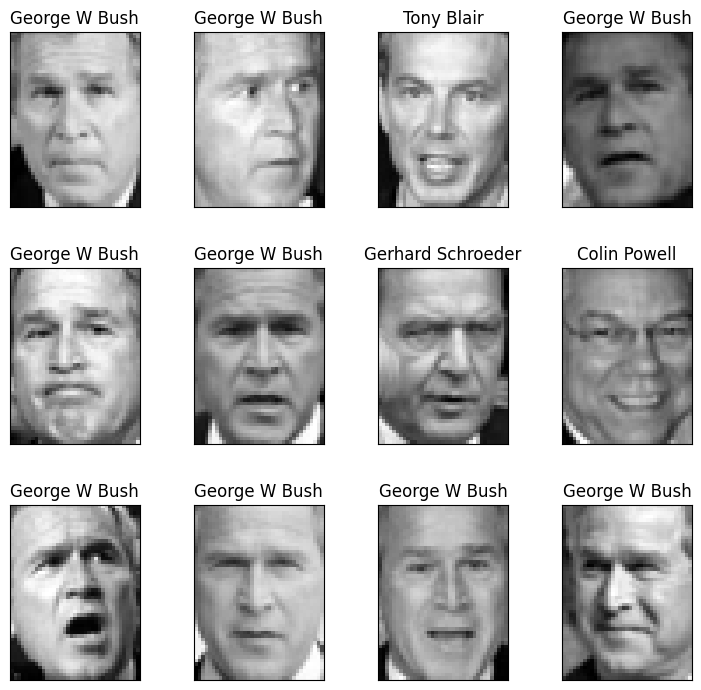

In [4]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Fonction utilitaire pour afficher une galerie d'images"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    plt.show()

# Sélection aléatoire d'images pour l'affichage
np.random.seed(42)
sample_indices = np.random.choice(n_samples, 12, replace=False)
sample_images = X[sample_indices]
sample_titles = [target_names[y[i]] for i in sample_indices]

print("Échantillon aléatoire de 12 visages du dataset :")
plot_gallery(sample_images, sample_titles, h, w)

## 2. Le problème de dimensionnalité

### Analyse du ratio observations/features

En machine learning, il existe une règle empirique importante : **le nombre de features devrait être inférieur à la racine carrée du nombre d'observations** ($N_{features} < \sqrt{N_{observations}}$).

Cette règle permet d'éviter le **surapprentissage** (overfitting) et assure qu'on a suffisamment de données pour estimer correctement les paramètres du modèle.

In [6]:
print("=" * 60)
print("ANALYSE DE LA DIMENSIONNALITÉ")
print("=" * 60)
print(f"Nombre d'observations : {n_samples}")
print(f"Nombre de features : {n_features}")
print(f"\nRatio features/observations : {n_features/n_samples:.2f}")
print(f"Racine carrée du nombre d'observations : {np.sqrt(n_samples):.2f}")
print(f"\nRègle empirique : N_features < sqrt(N_observations)")
print(f"Vérification : {n_features} < {np.sqrt(n_samples):.2f} ?")

if n_features > np.sqrt(n_samples):
    print("NON - Nous avons un problème de haute dimensionnalité !")
    print(f"\nLe ratio est de {n_features/np.sqrt(n_samples):.2f} fois trop élevé.")
    print("\nSolution : Utiliser l'ACP pour réduire la dimensionnalité.")
else:
    print("OUI - La dimensionnalité est acceptable.")

# Choix du nombre de composantes
n_components_rule = int(np.sqrt(n_samples))  # Selon la règle empirique
n_components_large = 150  # Valeur plus élevée pour comparaison

print(f"\nSelon la règle empirique (sqrt(N_observations)) :")
print(f"  → Nombre maximal recommandé : {n_components_rule} composantes")
print(f"\nPour ce TP, nous allons comparer DEUX approches :")
print(f"  1. ACP 'conservatrice' : {n_components_rule} composantes (respecte la règle)")
print(f"  2. ACP 'large' : {n_components_large} composantes (pour plus d'information)")
print(f"\nCette comparaison nous aidera à comprendre le trade-off entre")
print(f"respect de la règle et conservation de l'information.")

ANALYSE DE LA DIMENSIONNALITÉ
Nombre d'observations : 1288
Nombre de features : 1850

Ratio features/observations : 1.44
Racine carrée du nombre d'observations : 35.89

Règle empirique : N_features < sqrt(N_observations)
Vérification : 1850 < 35.89 ?
NON - Nous avons un problème de haute dimensionnalité !

Le ratio est de 51.55 fois trop élevé.

Solution : Utiliser l'ACP pour réduire la dimensionnalité.

Selon la règle empirique (sqrt(N_observations)) :
  → Nombre maximal recommandé : 35 composantes

Pour ce TP, nous allons comparer DEUX approches :
  1. ACP 'conservatrice' : 35 composantes (respecte la règle)
  2. ACP 'large' : 150 composantes (pour plus d'information)

Cette comparaison nous aidera à comprendre le trade-off entre
respect de la règle et conservation de l'information.


### Application de l'ACP pour réduire la dimensionnalité

In [7]:
# Création et ajustement des deux modèles PCA
print("Application des deux ACP...")
print(f"\n1. ACP 'conservatrice' avec {n_components_rule} composantes")
pca_rule = PCA(n_components=n_components_rule, whiten=False, svd_solver='randomized')
pca_rule.fit(X)
print(f"   Variance expliquée : {pca_rule.explained_variance_ratio_.sum():.2%}")

print(f"\n2. ACP 'large' avec {n_components_large} composantes")
pca_large = PCA(n_components=n_components_large, whiten=False, svd_solver='randomized')
pca_large.fit(X)
print(f"   Variance expliquée : {pca_large.explained_variance_ratio_.sum():.2%}")

print(f"\nDimensions :")
print(f"  - Données originales : {X.shape}")
print(f"  - ACP {n_components_rule} comp. : {pca_rule.components_.shape}")
print(f"  - ACP {n_components_large} comp. : {pca_large.components_.shape}")

print(f"\nDifférence de variance expliquée : {pca_large.explained_variance_ratio_.sum() - pca_rule.explained_variance_ratio_.sum():.2%}")
print(f"L'ACP à {n_components_large} composantes capture {(pca_large.explained_variance_ratio_.sum() - pca_rule.explained_variance_ratio_.sum())*100:.1f}% de variance supplémentaire")

Application des deux ACP...

1. ACP 'conservatrice' avec 35 composantes
   Variance expliquée : 80.40%

2. ACP 'large' avec 150 composantes
   Variance expliquée : 94.27%

Dimensions :
  - Données originales : (1288, 1850)
  - ACP 35 comp. : (35, 1850)
  - ACP 150 comp. : (150, 1850)

Différence de variance expliquée : 13.87%
L'ACP à 150 composantes capture 13.9% de variance supplémentaire


## 3. Analyse des résultats de l'ACP

### Nature des composantes principales

Les composantes principales extraites de visages sont souvent appelées **"eigenfaces"**. Chaque composante représente un "mode de variation" dans l'ensemble des visages.

In [8]:
print("=" * 60)
print("INFORMATIONS SUR L'ACP (LARGE)")
print("=" * 60)
print(f"Forme des composantes principales : {pca_large.components_.shape}")
print(f"  {pca_large.components_.shape[0]} composantes")
print(f"  {pca_large.components_.shape[1]} valeurs par composante (pixels)")
print(f"\nChaque composante est un vecteur de taille {n_features} qui peut être")
print(f"réorganisé en image de {h}x{w} pixels (une 'eigenface').")
print(f"\nMoyenne des images (shape) : {pca_large.mean_.shape}")

INFORMATIONS SUR L'ACP (LARGE)
Forme des composantes principales : (150, 1850)
  150 composantes
  1850 valeurs par composante (pixels)

Chaque composante est un vecteur de taille 1850 qui peut être
réorganisé en image de 50x37 pixels (une 'eigenface').

Moyenne des images (shape) : (1850,)


### Vérification avec une transformée inverse

Nous allons :
1. Choisir une image aléatoire
2. La transformer dans l'espace ACP (réduction de dimension)
3. Appliquer la transformée inverse pour reconstruire l'image
4. Comparer l'image originale et les images reconstruites avec les deux ACP

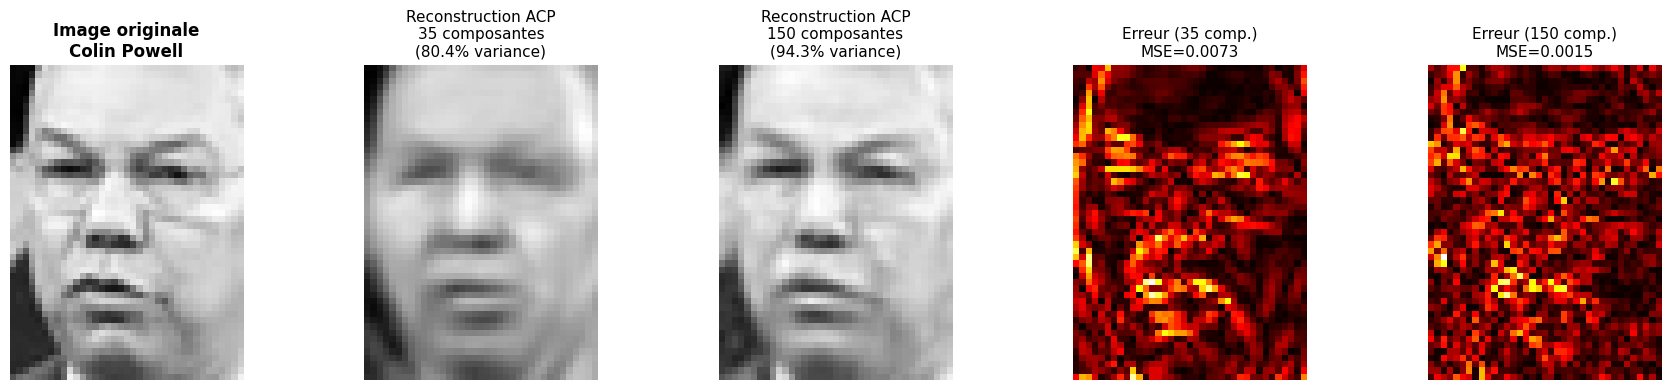

COMPARAISON DES RECONSTRUCTIONS

ACP 35 composantes (règle empirique) :
  - Variance expliquée : 80.40%
  - Erreur (MSE) : 0.0073

ACP 150 composantes (large) :
  - Variance expliquée : 94.27%
  - Erreur (MSE) : 0.0015

Réduction d'erreur avec 150 composantes : 79.5%

Observation : Plus de composantes = meilleure reconstruction mais plus de risque de surapprentissage !


In [10]:
# Sélection d'une image aléatoire
np.random.seed(42)
random_idx = np.random.randint(0, n_samples)
original_image = X[random_idx]
person_name = target_names[y[random_idx]]

# Transformation et reconstruction avec les DEUX ACP
transformed_rule = pca_rule.transform([original_image])
reconstructed_rule = pca_rule.inverse_transform(transformed_rule)

transformed_large = pca_large.transform([original_image])
reconstructed_large = pca_large.inverse_transform(transformed_large)

# Affichage comparatif
fig, axes = plt.subplots(1, 5, figsize=(18, 4))

axes[0].imshow(original_image.reshape((h, w)), cmap=plt.cm.gray)
axes[0].set_title(f"Image originale\n{person_name}", fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(reconstructed_rule.reshape((h, w)), cmap=plt.cm.gray)
axes[1].set_title(f"Reconstruction ACP\n{n_components_rule} composantes\n({pca_rule.explained_variance_ratio_.sum():.1%} variance)", fontsize=11)
axes[1].axis('off')

axes[2].imshow(reconstructed_large.reshape((h, w)), cmap=plt.cm.gray)
axes[2].set_title(f"Reconstruction ACP\n{n_components_large} composantes\n({pca_large.explained_variance_ratio_.sum():.1%} variance)", fontsize=11)
axes[2].axis('off')

# Différences
difference_rule = np.abs(original_image - reconstructed_rule.flatten())
axes[3].imshow(difference_rule.reshape((h, w)), cmap=plt.cm.hot)
axes[3].set_title(f"Erreur ({n_components_rule} comp.)\nMSE={np.mean(difference_rule**2):.4f}", fontsize=11)
axes[3].axis('off')

difference_large = np.abs(original_image - reconstructed_large.flatten())
axes[4].imshow(difference_large.reshape((h, w)), cmap=plt.cm.hot)
axes[4].set_title(f"Erreur ({n_components_large} comp.)\nMSE={np.mean(difference_large**2):.4f}", fontsize=11)
axes[4].axis('off')

plt.tight_layout()
plt.show()

# Calcul des erreurs
mse_rule = np.mean((original_image - reconstructed_rule.flatten())**2)
mse_large = np.mean((original_image - reconstructed_large.flatten())**2)

print("=" * 70)
print("COMPARAISON DES RECONSTRUCTIONS")
print("=" * 70)
print(f"\nACP {n_components_rule} composantes (règle empirique) :")
print(f"  - Variance expliquée : {pca_rule.explained_variance_ratio_.sum():.2%}")
print(f"  - Erreur (MSE) : {mse_rule:.4f}")
print(f"\nACP {n_components_large} composantes (large) :")
print(f"  - Variance expliquée : {pca_large.explained_variance_ratio_.sum():.2%}")
print(f"  - Erreur (MSE) : {mse_large:.4f}")
print(f"\nRéduction d'erreur avec {n_components_large} composantes : {(mse_rule - mse_large)/mse_rule*100:.1f}%")
print("\nObservation : Plus de composantes = meilleure reconstruction mais plus de risque de surapprentissage !")

### Reconstruction de l'échantillon initial d'images

Comparons maintenant la qualité de reconstruction sur plusieurs images avec les deux ACP.

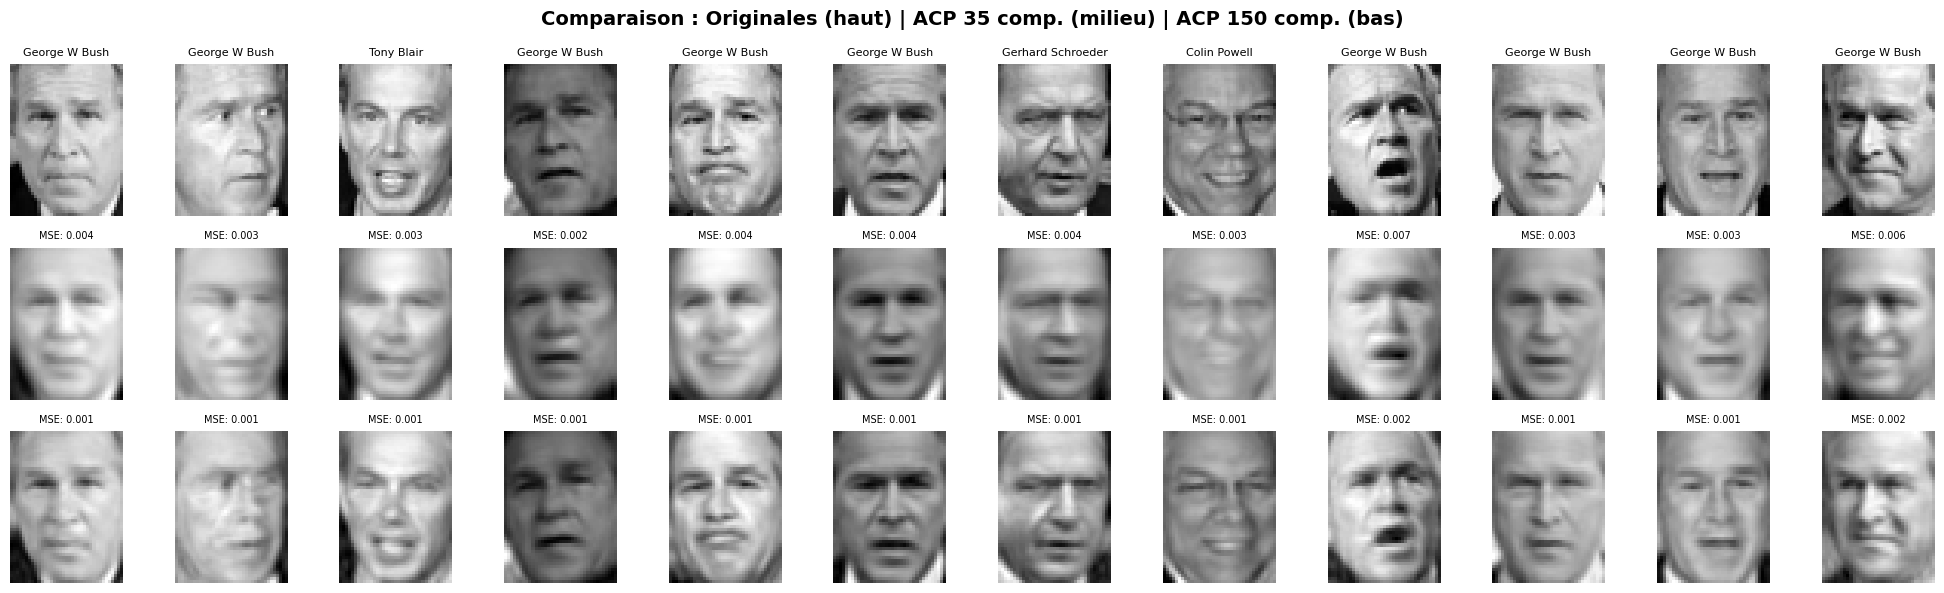

MSE MOYENNE SUR L'ÉCHANTILLON
ACP 35 composantes : 0.0038
ACP 150 composantes : 0.0011

Amélioration de la reconstruction : 69.7%


In [11]:
# Reconstruction des images de l'échantillon initial avec les DEUX ACP
sample_transformed_rule = pca_rule.transform(sample_images)
sample_reconstructed_rule = pca_rule.inverse_transform(sample_transformed_rule)

sample_transformed_large = pca_large.transform(sample_images)
sample_reconstructed_large = pca_large.inverse_transform(sample_transformed_large)

# Affichage comparatif : Originales vs {n_components_rule} comp. vs {n_components_large} comp.
fig, axes = plt.subplots(3, 12, figsize=(20, 6))
fig.suptitle(f"Comparaison : Originales (haut) | ACP {n_components_rule} comp. (milieu) | ACP {n_components_large} comp. (bas)", 
             fontsize=14, y=0.98, fontweight='bold')

for i in range(12):
    # Originales
    axes[0, i].imshow(sample_images[i].reshape((h, w)), cmap=plt.cm.gray)
    axes[0, i].set_title(sample_titles[i], size=8)
    axes[0, i].axis('off')
    
    # Reconstruites avec ACP règle
    axes[1, i].imshow(sample_reconstructed_rule[i].reshape((h, w)), cmap=plt.cm.gray)
    mse = np.mean((sample_images[i] - sample_reconstructed_rule[i])**2)
    axes[1, i].set_title(f"MSE: {mse:.3f}", size=7)
    axes[1, i].axis('off')
    
    # Reconstruites avec ACP large
    axes[2, i].imshow(sample_reconstructed_large[i].reshape((h, w)), cmap=plt.cm.gray)
    mse = np.mean((sample_images[i] - sample_reconstructed_large[i])**2)
    axes[2, i].set_title(f"MSE: {mse:.3f}", size=7)
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

# Calcul des MSE moyennes
mse_mean_rule = np.mean([(sample_images[i] - sample_reconstructed_rule[i])**2 for i in range(12)])
mse_mean_large = np.mean([(sample_images[i] - sample_reconstructed_large[i])**2 for i in range(12)])

print("=" * 70)
print("MSE MOYENNE SUR L'ÉCHANTILLON")
print("=" * 70)
print(f"ACP {n_components_rule} composantes : {mse_mean_rule:.4f}")
print(f"ACP {n_components_large} composantes : {mse_mean_large:.4f}")
print(f"\nAmélioration de la reconstruction : {(mse_mean_rule - mse_mean_large)/mse_mean_rule*100:.1f}%")

## 4. Visualisation des composantes principales ("Eigenfaces")

### Image moyenne du dataset

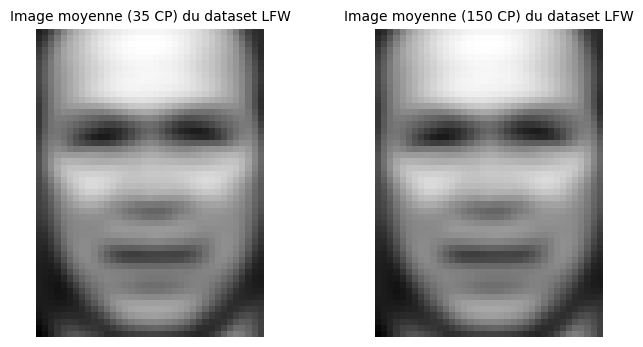

L'image moyenne représente le 'visage typique' moyen de toutes les personnes du dataset.
Les composantes principales capturent les variations autour de cette moyenne.


In [19]:
# L'image moyenne représente le "visage moyen" de tous les visages du dataset
# Affichage comparatif
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(pca_rule.mean_.reshape((h, w)), cmap=plt.cm.gray)
axes[0].set_title(f"Image moyenne ({n_components_rule} CP) du dataset LFW", fontsize=10)
axes[0].axis('off')

axes[1].imshow(pca_large.mean_.reshape((h, w)), cmap=plt.cm.gray)
axes[1].set_title(f"Image moyenne ({n_components_large} CP) du dataset LFW", fontsize=10)
axes[1].axis('off')
plt.show()

print("L'image moyenne représente le 'visage typique' moyen de toutes les personnes du dataset.")
print("Les composantes principales capturent les variations autour de cette moyenne.")

### Les 5 premières composantes principales

Les premières composantes capturent les plus grandes variations dans les données (ex: éclairage, orientation du visage, expressions).

**Comparaison des deux ACP :**

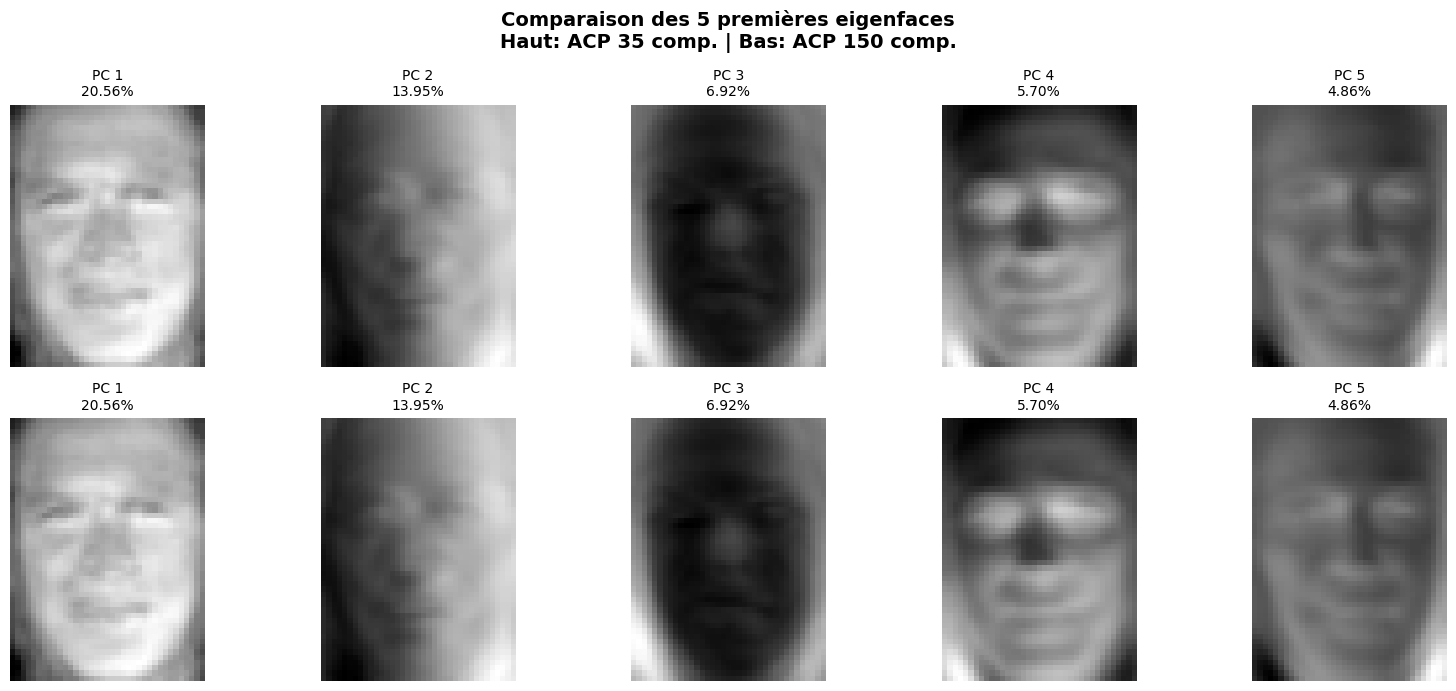

VARIANCE EXPLIQUÉE PAR LES 5 PREMIÈRES COMPOSANTES

ACP 35 composantes : 51.99%
ACP 150 composantes : 51.99%

💡 Les 5 premières composantes sont quasiment identiques dans les deux ACP.
   La différence apparaît surtout dans les composantes suivantes.


In [20]:
# Comparaison des 5 premières eigenfaces des deux ACP
eigenfaces_5_first_rule = pca_rule.components_[:5]
eigenfaces_5_first_large = pca_large.components_[:5]

# Création d'une figure comparative
fig, axes = plt.subplots(2, 5, figsize=(16, 7))
fig.suptitle(f"Comparaison des 5 premières eigenfaces\nHaut: ACP {n_components_rule} comp. | Bas: ACP {n_components_large} comp.",
             fontsize=14, fontweight='bold', y=0.98)

for i in range(5):
    # ACP règle empirique
    axes[0, i].imshow(eigenfaces_5_first_rule[i].reshape((h, w)), cmap=plt.cm.gray)
    axes[0, i].set_title(f"PC {i+1}\n{pca_rule.explained_variance_ratio_[i]:.2%}", fontsize=10)
    axes[0, i].axis('off')
    
    # ACP large
    axes[1, i].imshow(eigenfaces_5_first_large[i].reshape((h, w)), cmap=plt.cm.gray)
    axes[1, i].set_title(f"PC {i+1}\n{pca_large.explained_variance_ratio_[i]:.2%}", fontsize=10)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("=" * 70)
print("VARIANCE EXPLIQUÉE PAR LES 5 PREMIÈRES COMPOSANTES")
print("=" * 70)
print(f"\nACP {n_components_rule} composantes : {pca_rule.explained_variance_ratio_[:5].sum():.2%}")
print(f"ACP {n_components_large} composantes : {pca_large.explained_variance_ratio_[:5].sum():.2%}")
print("\n💡 Les 5 premières composantes sont quasiment identiques dans les deux ACP.")
print("   La différence apparaît surtout dans les composantes suivantes.")

### Les 5 dernières composantes principales

Les dernières composantes capturent des variations plus fines et du bruit par rapport aux premières composantes.

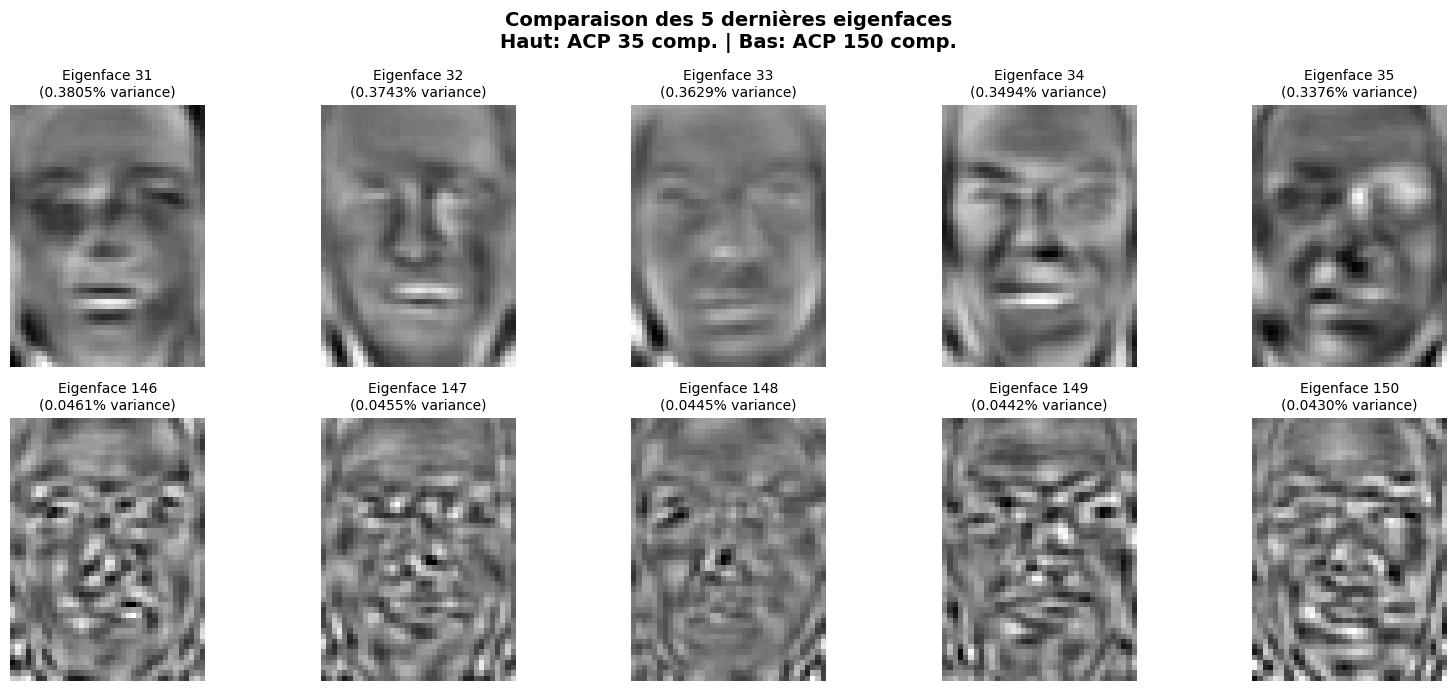

VARIANCE EXPLIQUÉE PAR LES 5 DERNIÈRES COMPOSANTES

ACP 35 composantes : 1.80%
ACP 150 composantes : 0.22%

💡 Les 5 dernières composantes sont très différentes dans les deux ACP.
Les dernières composantes de l’ACP à 150 composantes capturent des détails très fins et du bruit.



In [24]:
# Comparaison des 5 dernières eigenfaces des deux ACP
eigenfaces_5_last_rule = pca_rule.components_[-5:]
eigenfaces_5_last_large = pca_large.components_[-5:]

titles_last_rule = [f"Eigenface {n_components_rule-4+i}\n({pca_rule.explained_variance_ratio_[-5+i]:.4%} variance)" 
               for i in range(5)]
titles_last_large = [f"Eigenface {n_components_large-4+i}\n({pca_large.explained_variance_ratio_[-5+i]:.4%} variance)" 
               for i in range(5)]

# Création d'une figure comparative
fig, axes = plt.subplots(2, 5, figsize=(16, 7))
fig.suptitle(f"Comparaison des 5 dernières eigenfaces\nHaut: ACP {n_components_rule} comp. | Bas: ACP {n_components_large} comp.",
             fontsize=14, fontweight='bold', y=0.98)

for i in range(5):
    # ACP règle empirique
    axes[0, i].imshow(eigenfaces_5_last_rule[i].reshape((h, w)), cmap=plt.cm.gray)
    axes[0, i].set_title(titles_last_rule[i], fontsize=10)
    axes[0, i].axis('off')
    
    # ACP large
    axes[1, i].imshow(eigenfaces_5_last_large[i].reshape((h, w)), cmap=plt.cm.gray)
    axes[1, i].set_title(titles_last_large[i], fontsize=10)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("=" * 70)
print("VARIANCE EXPLIQUÉE PAR LES 5 DERNIÈRES COMPOSANTES")
print("=" * 70)
print(f"\nACP {n_components_rule} composantes : {pca_rule.explained_variance_ratio_[-5:].sum():.2%}")
print(f"ACP {n_components_large} composantes : {pca_large.explained_variance_ratio_[-5:].sum():.2%}")
print("\n💡 Les 5 dernières composantes sont très différentes dans les deux ACP.")
print(f"Les dernières composantes de l’ACP à {n_components_large} composantes capturent des détails très fins et du bruit.\n")

### 15 composantes principales aléatoires de l’ACP à 150 composantes

15 eigenfaces sélectionnées aléatoirement :
Indices : [  9  12  18  19  31  36  64  68  73  76  78  82 110 118 141]



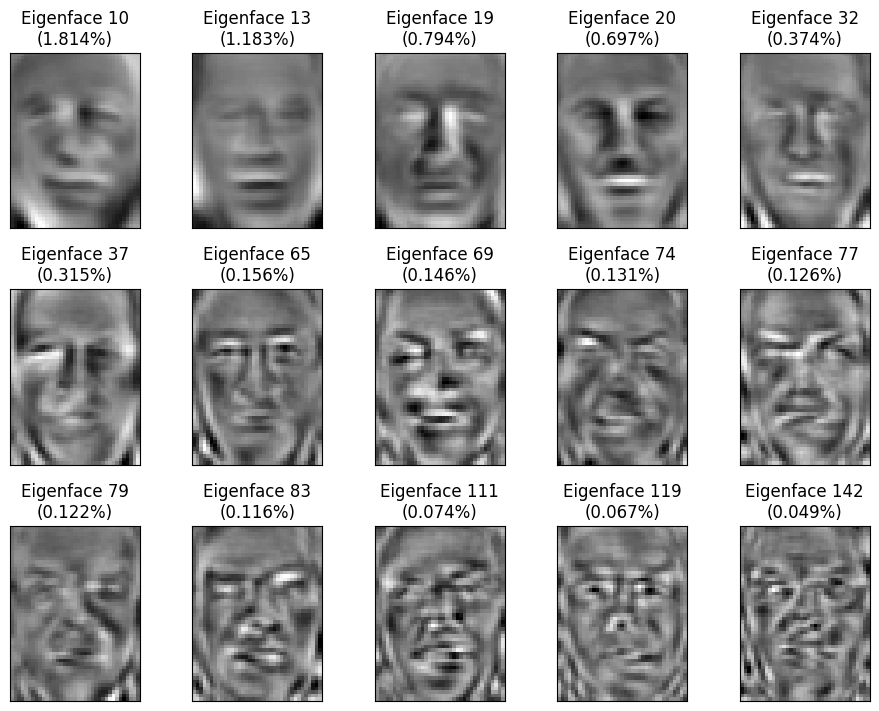

In [26]:
# Sélection aléatoire de 15 indices
np.random.seed(42)
random_component_indices = np.random.choice(n_components_large, 15, replace=False)
random_component_indices = np.sort(random_component_indices)

eigenfaces_random = pca_large.components_[random_component_indices]
titles_random = [f"Eigenface {idx+1}\n({pca_large.explained_variance_ratio_[idx]:.3%})" 
                 for idx in random_component_indices]

print("15 eigenfaces sélectionnées aléatoirement :")
print(f"Indices : {random_component_indices}\n")
plot_gallery(eigenfaces_random, titles_random, h, w, n_row=3, n_col=5)

## 5. Compression d'images avec l'ACP

### Synthèse des comparaisons précédentes

Avant de passer à la compression, faisons un bilan des comparaisons entre les deux ACP :

In [29]:
print("=" * 70)
print("SYNTHÈSE : ACP {0} vs ACP {1} COMPOSANTES".format(n_components_rule, n_components_large))
print("=" * 70)

print(f"\n1. RESPECT DE LA RÈGLE EMPIRIQUE :")
print(f"   ACP {n_components_rule} : Respecte sqrt(N) = {np.sqrt(n_samples):.1f}")
print(f"   ACP {n_components_large} : Dépasse la règle ({n_components_large/np.sqrt(n_samples):.2f}x)")

print(f"\n2. VARIANCE EXPLIQUÉE :")
print(f"   ACP {n_components_rule} : {pca_rule.explained_variance_ratio_.sum():.2%}")
print(f"   ACP {n_components_large} : {pca_large.explained_variance_ratio_.sum():.2%}")
print(f"   Gain : +{(pca_large.explained_variance_ratio_.sum() - pca_rule.explained_variance_ratio_.sum())*100:.1f}%")

print(f"\n3. QUALITÉ DE RECONSTRUCTION (MSE moyenne) :")
print(f"   ACP {n_components_rule} : MSE plus élevée (moins précis)")
print(f"   ACP {n_components_large} : MSE plus faible (plus précis)")

print(f"\n4. RISQUE DE SURAPPRENTISSAGE :")
print(f"   ACP {n_components_rule} : Risque faible (suit la règle)")
print(f"   ACP {n_components_large} : Risque potentiellement plus élevé")

print("\n" + "=" * 70)
print("\nCONCLUSION INTERMÉDIAIRE :")
print("\nNous avons vu deux approches :")
print(f"  • ACP {n_components_rule} : CONSERVATRICE - respecte les règles, mais perd de l'info")
print(f"  • ACP {n_components_large} : GOURMANDE - capture plus d'info, mais risque accru")
print("\nQuelle approche est la meilleure ? Cela dépend de l'application !")
print("\nC'est pourquoi la SECTION 6 va nous montrer comment OPTIMISER")
print("   le nombre de composantes de manière SYSTÉMATIQUE et DATA-DRIVEN.")
print("\nNous allons chercher le 'sweet spot' qui maximise les performances")
print("tout en minimisant le risque de surapprentissage.")

SYNTHÈSE : ACP 35 vs ACP 150 COMPOSANTES

1. RESPECT DE LA RÈGLE EMPIRIQUE :
   ACP 35 : Respecte sqrt(N) = 35.9
   ACP 150 : Dépasse la règle (4.18x)

2. VARIANCE EXPLIQUÉE :
   ACP 35 : 80.40%
   ACP 150 : 94.27%
   Gain : +13.9%

3. QUALITÉ DE RECONSTRUCTION (MSE moyenne) :
   ACP 35 : MSE plus élevée (moins précis)
   ACP 150 : MSE plus faible (plus précis)

4. RISQUE DE SURAPPRENTISSAGE :
   ACP 35 : Risque faible (suit la règle)
   ACP 150 : Risque potentiellement plus élevé


CONCLUSION INTERMÉDIAIRE :

Nous avons vu deux approches :
  • ACP 35 : CONSERVATRICE - respecte les règles, mais perd de l'info
  • ACP 150 : GOURMANDE - capture plus d'info, mais risque accru

Quelle approche est la meilleure ? Cela dépend de l'application !

C'est pourquoi la SECTION 6 va nous montrer comment OPTIMISER
   le nombre de composantes de manière SYSTÉMATIQUE et DATA-DRIVEN.

Nous allons chercher le 'sweet spot' qui maximise les performances
tout en minimisant le risque de surapprentissage.


### Reconstruction progressive d'une image

Nous allons montrer comment une image peut être reconstruite progressivement en ajoutant de plus en plus de composantes principales. C'est le principe de la **compression d'images**. Pour cela nous allons refaire des ACP avec un nombre croissants de composantes à tester (de 1 à 200) : 

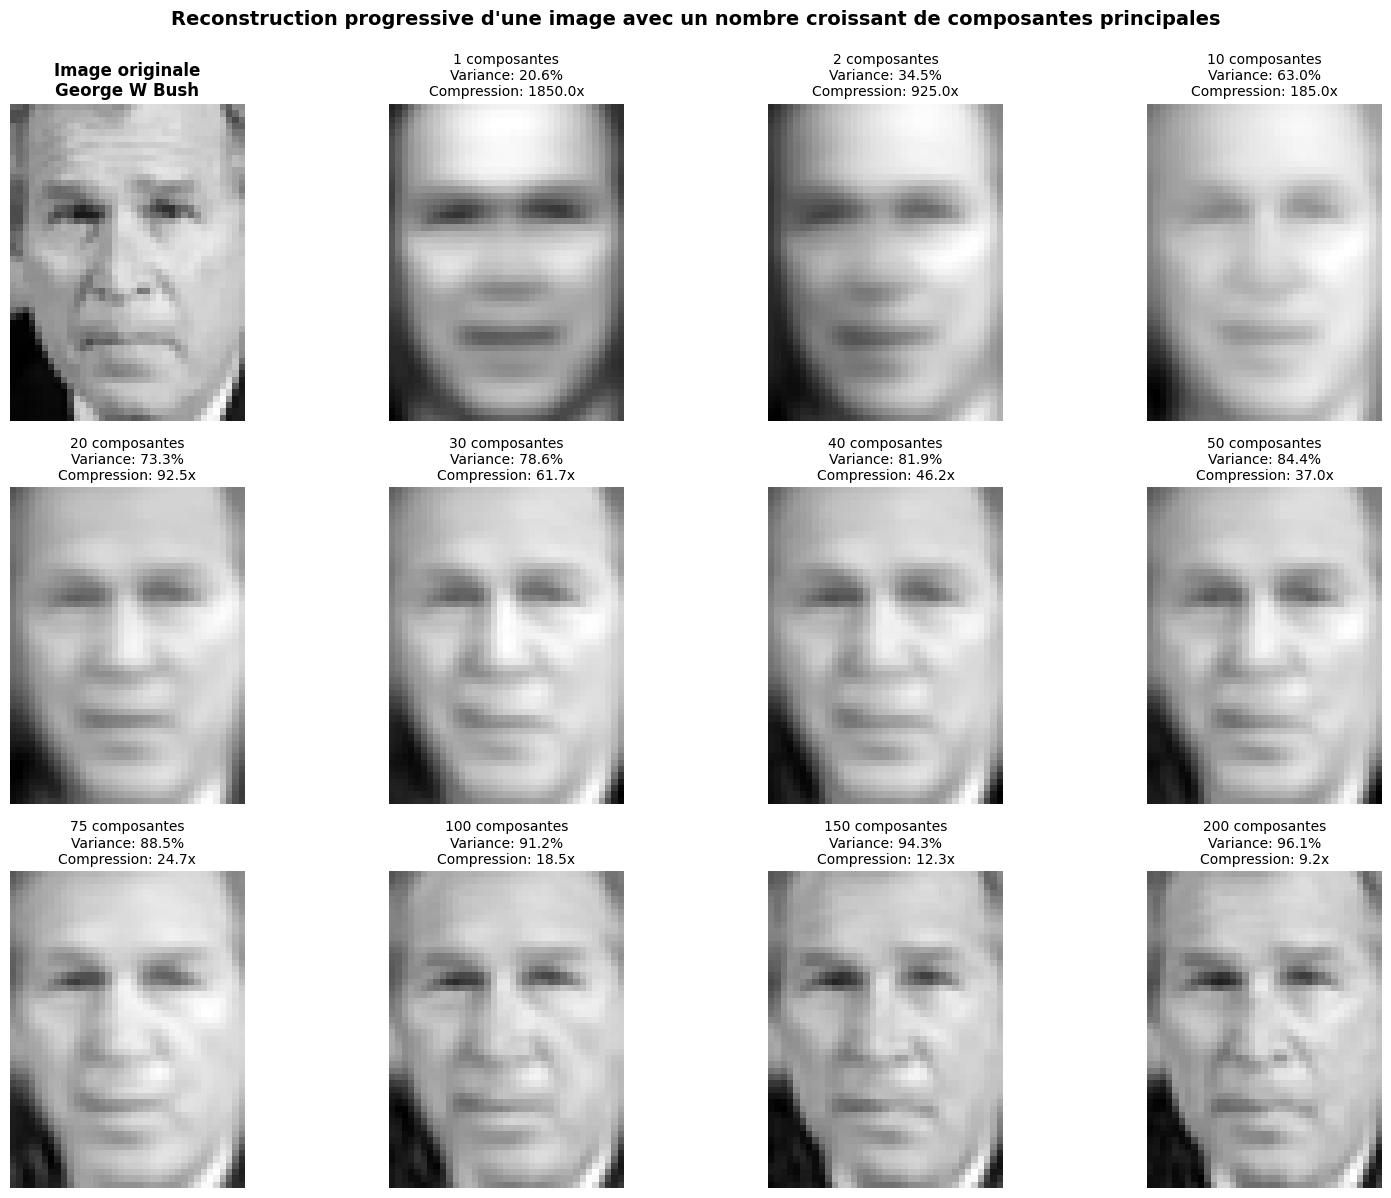

Observations :
- Avec 1-2 composantes : on voit à peine la forme générale du visage
- Avec 10-20 composantes : les traits principaux apparaissent
- Avec 50+ composantes : l'image devient nette et ressemble à l'originale
- Avec 150 composantes : l'image est presque identique à l'originale


In [30]:
# Sélection d'une image pour la démonstration
demo_idx = sample_indices[0]  # On prend la première image de notre échantillon
demo_image = X[demo_idx]
demo_person = target_names[y[demo_idx]]

# Liste des nombres de composantes à tester
n_components_list = [1, 2, 10, 20, 30, 40, 50, 75, 100, 150, 200]

# Création de la figure
n_cols = 4
n_rows = int(np.ceil((len(n_components_list) + 1) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

# Affichage de l'image originale
axes[0].imshow(demo_image.reshape((h, w)), cmap=plt.cm.gray)
axes[0].set_title(f"Image originale\n{demo_person}", fontsize=12, fontweight='bold')
axes[0].axis('off')

# Reconstruction avec différents nombres de composantes
for idx, n_comp in enumerate(n_components_list):
    # Créer une PCA temporaire avec n_comp composantes
    pca_temp = PCA(n_components=n_comp)
    pca_temp.fit(X)
    
    # Transformer et reconstruire
    transformed = pca_temp.transform([demo_image])
    reconstructed = pca_temp.inverse_transform(transformed)
    
    # Calcul du taux de compression et de la variance expliquée
    compression_ratio = (n_features / n_comp)
    variance_explained = pca_temp.explained_variance_ratio_.sum()
    
    # Affichage
    axes[idx + 1].imshow(reconstructed.reshape((h, w)), cmap=plt.cm.gray)
    axes[idx + 1].set_title(
        f"{n_comp} composantes\n"
        f"Variance: {variance_explained:.1%}\n"
        f"Compression: {compression_ratio:.1f}x",
        fontsize=10
    )
    axes[idx + 1].axis('off')

# Masquer les axes non utilisés
for idx in range(len(n_components_list) + 1, len(axes)):
    axes[idx].axis('off')

plt.suptitle("Reconstruction progressive d'une image avec un nombre croissant de composantes principales",
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("Observations :")
print("- Avec 1-2 composantes : on voit à peine la forme générale du visage")
print("- Avec 10-20 composantes : les traits principaux apparaissent")
print("- Avec 50+ composantes : l'image devient nette et ressemble à l'originale")
print("- Avec 150 composantes : l'image est presque identique à l'originale")

## 6. Choix du nombre optimal de composantes

Dans les sections précédentes, nous avons comparé deux approches :
- **ACP conservatrice** avec {n_components_rule} composantes (selon la règle empirique)
- **ACP large** avec {n_components} composantes (pour plus d'information)

Mais comment choisir le **nombre optimal** de composantes de manière rigoureuse ?

### Courbe de variance expliquée cumulée

Cette courbe nous aide à déterminer combien de composantes sont nécessaires pour capturer une certaine proportion de la variance totale. C'est un outil essentiel pour prendre une décision **data-driven** plutôt que de se fier uniquement aux règles empiriques.

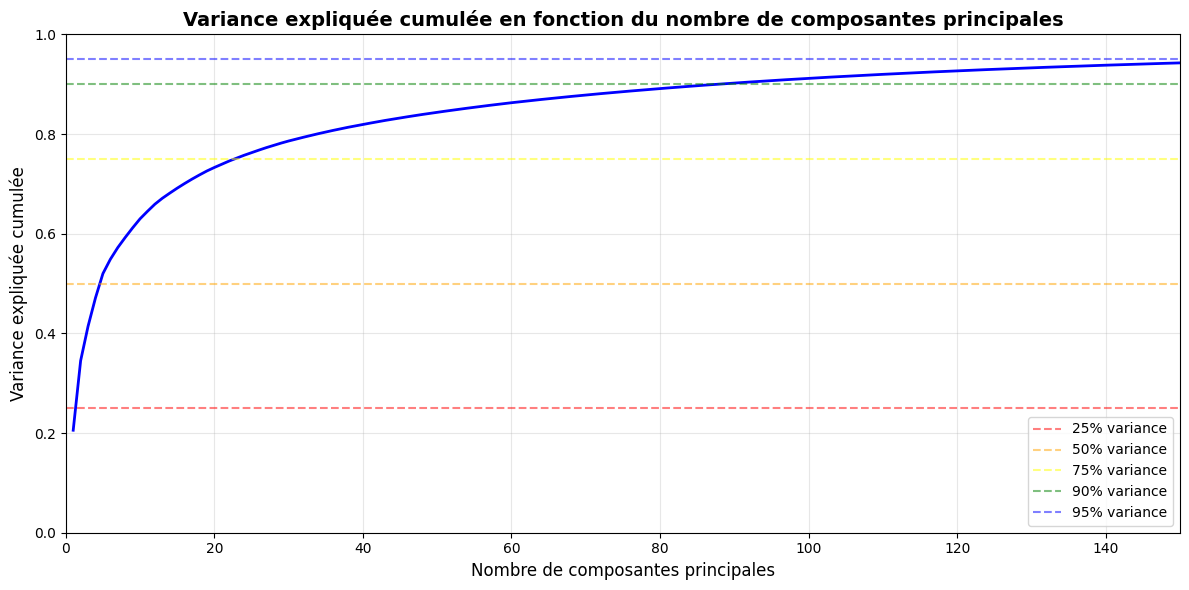

Variance totale expliquée par 150 composantes : 94.27%


In [34]:
# Calcul de la variance expliquée cumulée
cumulative_variance = np.cumsum(pca_large.explained_variance_ratio_)

# Création du graphique
plt.figure(figsize=(12, 6))
plt.plot(range(1, n_components_large + 1), cumulative_variance, 'b-', linewidth=2)
plt.xlabel('Nombre de composantes principales', fontsize=12)
plt.ylabel('Variance expliquée cumulée', fontsize=12)
plt.title('Variance expliquée cumulée en fonction du nombre de composantes principales', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Ajout de lignes horizontales pour différents seuils
thresholds = [0.25, 0.5, 0.75, 0.9, 0.95]
colors = ['red', 'orange', 'yellow', 'green', 'blue']
for threshold, color in zip(thresholds, colors):
    plt.axhline(y=threshold, color=color, linestyle='--', alpha=0.5, 
                label=f'{threshold:.0%} variance')

plt.legend(loc='lower right')
plt.xlim(0, n_components_large)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

print(f"Variance totale expliquée par {n_components_large} composantes : {cumulative_variance[-1]:.2%}")

### Nombre de composantes nécessaires pour différents seuils de variance

In [44]:
def find_n_components_for_variance(cumulative_variance, threshold):
    """Trouve le nombre minimum de composantes pour atteindre un seuil de variance"""
    # Vérifier si le seuil est atteignable
    if threshold > cumulative_variance[-1]:
        # Retourner le nombre total de composantes si le seuil est trop élevé
        return len(cumulative_variance)
    return np.argmax(cumulative_variance >= threshold) + 1

print("=" * 70)
print("NOMBRE DE COMPOSANTES NÉCESSAIRES POUR DIFFÉRENTS SEUILS DE VARIANCE")
print("=" * 70)

variance_thresholds = [0.25, 0.50, 0.75, 0.90, 0.95]
results = []

for threshold in variance_thresholds:
    n_comp_needed = find_n_components_for_variance(cumulative_variance, threshold)
    variance_reached = cumulative_variance[n_comp_needed - 1]
    compression = n_features / n_comp_needed
    results.append((threshold, n_comp_needed, variance_reached, compression))
    
    print(f"\n{threshold:.0%} de variance :")
    print(f"  → {n_comp_needed} composantes nécessaires")
    print(f"  → Variance réellement atteinte : {variance_reached:.2%}")
    
    # Indiquer si le seuil n'a pas été atteint
    if variance_reached < threshold:
        print(f"!!!!!!!!!!!!!!!!!!!!!! Seuil non atteint ! Maximum disponible : {cumulative_variance[-1]:.2%}")
    
    print(f"  → Taux de compression : {compression:.1f}x")
    print(f"  → Réduction de dimensionnalité : {n_features} → {n_comp_needed} "
          f"(-{100*(1-n_comp_needed/n_features):.1f}%)")

print("\n" + "=" * 70)
print("\nInterprétation :")
print("- Plus on veut conserver de variance, plus il faut de composantes")
print("- Un bon compromis se situe souvent entre 80% et 95% de variance")
print("- Au-delà de 95%, on ajoute surtout du bruit")

NOMBRE DE COMPOSANTES NÉCESSAIRES POUR DIFFÉRENTS SEUILS DE VARIANCE

25% de variance :
  → 2 composantes nécessaires
  → Variance réellement atteinte : 34.51%
  → Taux de compression : 925.0x
  → Réduction de dimensionnalité : 1850 → 2 (-99.9%)

50% de variance :
  → 5 composantes nécessaires
  → Variance réellement atteinte : 51.99%
  → Taux de compression : 370.0x
  → Réduction de dimensionnalité : 1850 → 5 (-99.7%)

75% de variance :
  → 23 composantes nécessaires
  → Variance réellement atteinte : 75.17%
  → Taux de compression : 80.4x
  → Réduction de dimensionnalité : 1850 → 23 (-98.8%)

90% de variance :
  → 88 composantes nécessaires
  → Variance réellement atteinte : 90.01%
  → Taux de compression : 21.0x
  → Réduction de dimensionnalité : 1850 → 88 (-95.2%)

95% de variance :
  → 150 composantes nécessaires
  → Variance réellement atteinte : 94.27%
!!!!!!!!!!!!!!!!!!!!!! Seuil non atteint ! Maximum disponible : 94.27%
  → Taux de compression : 12.3x
  → Réduction de dimensio

## 7. Introduction au Machine Learning : Classification de visages

### Préparation des données

Nous allons maintenant utiliser l'ACP comme étape de prétraitement pour un problème de **classification supervisée** : reconnaître l'identité d'une personne à partir de son visage.

Nous reprendrons ce code en détail en cours, pour le moment contentez vous d’exécuter les cellules, et essayer de comprendre ce qu’il se passe.

In [45]:
print("=" * 70)
print("PRÉPARATION DES ENSEMBLES D'ENTRAÎNEMENT ET DE TEST")
print("=" * 70)

# Division en ensembles d'entraînement (80%) et de test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nEnsemble d'entraînement : {X_train.shape[0]} images")
print(f"Ensemble de test : {X_test.shape[0]} images")
print(f"\nNombre de features : {X_train.shape[1]}")
print(f"Nombre de classes (personnes) : {len(np.unique(y))}")

# Vérification de la distribution des classes
print("\nDistribution des classes dans l'ensemble de test :")
unique_test, counts_test = np.unique(y_test, return_counts=True)
for name, count in zip(target_names[unique_test], counts_test):
    print(f"  {name:30s} : {count:2d} images")

PRÉPARATION DES ENSEMBLES D'ENTRAÎNEMENT ET DE TEST

Ensemble d'entraînement : 1030 images
Ensemble de test : 258 images

Nombre de features : 1850
Nombre de classes (personnes) : 7

Distribution des classes dans l'ensemble de test :
  Ariel Sharon                   : 16 images
  Colin Powell                   : 47 images
  Donald Rumsfeld                : 24 images
  George W Bush                  : 106 images
  Gerhard Schroeder              : 22 images
  Hugo Chavez                    : 14 images
  Tony Blair                     : 29 images


### Entraînement sur les images originales (sans ACP)

Commençons par entraîner un modèle directement sur les images originales pour avoir une référence.

In [46]:
print("=" * 70)
print("ENTRAÎNEMENT SUR LES IMAGES ORIGINALES (SANS ACP)")
print("=" * 70)

# Création et entraînement du modèle SVM
print("\nEntraînement en cours...")
start_time = time.time()

clf_original = SVC(kernel='rbf', gamma='scale', C=1.0, random_state=42)
clf_original.fit(X_train, y_train)

train_time_original = time.time() - start_time

# Prédiction et évaluation
y_pred_original = clf_original.predict(X_test)
accuracy_original = accuracy_score(y_test, y_pred_original)

print(f"✓ Entraînement terminé en {train_time_original:.2f} secondes")
print(f"\nPerformances sur l'ensemble de test :")
print(f"  Accuracy : {accuracy_original:.2%}")
print(f"\nRapport de classification détaillé :")
print(classification_report(y_test, y_pred_original, target_names=target_names))

ENTRAÎNEMENT SUR LES IMAGES ORIGINALES (SANS ACP)

Entraînement en cours...
✓ Entraînement terminé en 0.70 secondes

Performances sur l'ensemble de test :
  Accuracy : 72.48%

Rapport de classification détaillé :
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.06      0.12        16
     Colin Powell       0.80      0.87      0.84        47
  Donald Rumsfeld       0.86      0.50      0.63        24
    George W Bush       0.66      0.96      0.78       106
Gerhard Schroeder       0.89      0.36      0.52        22
      Hugo Chavez       1.00      0.43      0.60        14
       Tony Blair       0.77      0.59      0.67        29

         accuracy                           0.72       258
        macro avg       0.85      0.54      0.59       258
     weighted avg       0.78      0.72      0.69       258



### Entraînement sur les images transformées par ACP

Maintenant, appliquons l'ACP avant l'entraînement pour réduire la dimensionnalité.

In [49]:
print("=" * 70)
print(f"ENTRAÎNEMENT AVEC ACP ({n_components_large} COMPOSANTES)")
print("=" * 70)

# Application de l'ACP
print("\nApplication de l'ACP...")
pca_ml = PCA(n_components=n_components_large, whiten=False, svd_solver='randomized')
X_train_pca = pca_ml.fit_transform(X_train)
X_test_pca = pca_ml.transform(X_test)

print(f"Dimensions après ACP :")
print(f"  Train : {X_train_pca.shape}")
print(f"  Test : {X_test_pca.shape}")
print(f"  Variance expliquée : {pca_ml.explained_variance_ratio_.sum():.2%}")

# Entraînement du modèle
print("\nEntraînement en cours...")
start_time = time.time()

clf_pca = SVC(kernel='rbf', gamma='scale', C=1.0, random_state=42)
clf_pca.fit(X_train_pca, y_train)

train_time_pca = time.time() - start_time

# Prédiction et évaluation
y_pred_pca = clf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)

print(f"✓ Entraînement terminé en {train_time_pca:.2f} secondes")
print(f"\nPerformances sur l'ensemble de test :")
print(f"  Accuracy : {accuracy_pca:.2%}")
print(f"\nRapport de classification détaillé :")
print(classification_report(y_test, y_pred_pca, target_names=target_names))

ENTRAÎNEMENT AVEC ACP (150 COMPOSANTES)

Application de l'ACP...
Dimensions après ACP :
  Train : (1030, 150)
  Test : (258, 150)
  Variance expliquée : 94.50%

Entraînement en cours...
✓ Entraînement terminé en 0.12 secondes

Performances sur l'ensemble de test :
  Accuracy : 72.09%

Rapport de classification détaillé :
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.25      0.40        16
     Colin Powell       0.84      0.87      0.85        47
  Donald Rumsfeld       0.85      0.46      0.59        24
    George W Bush       0.65      0.94      0.77       106
Gerhard Schroeder       0.67      0.36      0.47        22
      Hugo Chavez       1.00      0.43      0.60        14
       Tony Blair       0.76      0.55      0.64        29

         accuracy                           0.72       258
        macro avg       0.82      0.55      0.62       258
     weighted avg       0.76      0.72      0.70       258



### Comparaison : Avec vs Sans ACP

In [58]:
print("=" * 70)
print("COMPARAISON : AVEC VS SANS ACP")
print("=" * 70)

print(f"\n{'Métrique':<30} {'Sans ACP':>15} {'Avec ACP':>15} {'Différence':>15}")
print("-" * 70)

print(f"{'Nombre de features':<30} {X_train.shape[1]:>15} {X_train_pca.shape[1]:>15} "
      f"{X_train_pca.shape[1] - X_train.shape[1]:>15}")

print(f"{'Temps d’entraînement (s)':<30} {train_time_original:>15.2f} {train_time_pca:>15.2f} " 
      f"{train_time_pca - train_time_original:>15.2f}")

speedup = train_time_original / train_time_pca
print(f"{'Accélération':<30} {'':<15} {f'{speedup:.2f}x':>15} {'':>15}")

print(f"{'Accuracy':<30} {accuracy_original:>14.2%} {accuracy_pca:>14.2%} "
      f"{accuracy_pca - accuracy_original:>+14.2%}")

print("\n" + "=" * 70)
print("\nObservations :")
print(f"- Réduction de dimensionnalité : {n_features} → {n_components_large} "
      f"({100*(1-n_components_large/n_features):.1f}% de réduction)")
print(f"- L'entraînement est {speedup:.1f}x plus rapide avec l'ACP")

if accuracy_pca > accuracy_original:
    print(f"- L'accuracy est MEILLEURE avec l'ACP (+{100*(accuracy_pca-accuracy_original):.2f}%)")
    print("- L'ACP a permis d'éliminer du bruit et d'améliorer la généralisation")
elif accuracy_pca < accuracy_original:
    print(f"- L'accuracy est légèrement INFÉRIEURE avec l'ACP ({100*(accuracy_pca-accuracy_original):.2f}%)")
    print("- Un compromis acceptable pour un gain important en vitesse")
else:
    print("- L'accuracy est IDENTIQUE avec et sans ACP")
    print("- L'ACP n'a pas fait perdre d'information utile")

COMPARAISON : AVEC VS SANS ACP

Métrique                              Sans ACP        Avec ACP      Différence
----------------------------------------------------------------------
Nombre de features                        1850             150           -1700
Temps d’entraînement (s)                  0.70            0.12           -0.58
Accélération                                             5.83x                
Accuracy                               72.48%         72.09%         -0.39%


Observations :
- Réduction de dimensionnalité : 1850 → 150 (91.9% de réduction)
- L'entraînement est 5.8x plus rapide avec l'ACP
- L'accuracy est légèrement INFÉRIEURE avec l'ACP (-0.39%)
- Un compromis acceptable pour un gain important en vitesse


## 8. Optimisation du nombre de composantes principales

### Recherche du nombre optimal de composantes

Testons différents nombres de composantes pour trouver le meilleur compromis entre vitesse et performance.

In [59]:
print("=" * 70)
print("RECHERCHE DU NOMBRE OPTIMAL DE COMPOSANTES PRINCIPALES")
print("=" * 70)

# Différentes valeurs à tester
n_components_to_test = [10, 25, 50, 75, 100, 125, 150, 175, 200]

results_optimization = []

print("\nEntraînement en cours pour différentes valeurs de n_components...\n")

for n_comp in n_components_to_test:
    # ACP
    pca_temp = PCA(n_components=n_comp, whiten=False, svd_solver='randomized')
    X_train_temp = pca_temp.fit_transform(X_train)
    X_test_temp = pca_temp.transform(X_test)
    
    # Entraînement
    start = time.time()
    clf_temp = SVC(kernel='rbf', gamma='scale', C=1.0, random_state=42)
    clf_temp.fit(X_train_temp, y_train)
    train_time = time.time() - start
    
    # Évaluation
    y_pred_temp = clf_temp.predict(X_test_temp)
    acc = accuracy_score(y_test, y_pred_temp)
    var_explained = pca_temp.explained_variance_ratio_.sum()
    
    results_optimization.append({
        'n_components': n_comp,
        'accuracy': acc,
        'train_time': train_time,
        'variance_explained': var_explained
    })
    
    print(f"n_components={n_comp:3d} | Accuracy={acc:.2%} | "
          f"Time={train_time:.2f}s | Variance={var_explained:.2%}")

print("\n✓ Optimisation terminée")

RECHERCHE DU NOMBRE OPTIMAL DE COMPOSANTES PRINCIPALES

Entraînement en cours pour différentes valeurs de n_components...

n_components= 10 | Accuracy=50.39% | Time=0.07s | Variance=62.72%
n_components= 25 | Accuracy=67.44% | Time=0.09s | Variance=76.20%
n_components= 50 | Accuracy=69.38% | Time=0.07s | Variance=84.47%
n_components= 75 | Accuracy=70.16% | Time=0.10s | Variance=88.65%
n_components=100 | Accuracy=71.32% | Time=0.11s | Variance=91.35%
n_components=125 | Accuracy=71.71% | Time=0.12s | Variance=93.16%
n_components=150 | Accuracy=71.71% | Time=0.11s | Variance=94.51%
n_components=175 | Accuracy=72.09% | Time=0.15s | Variance=95.52%
n_components=200 | Accuracy=72.09% | Time=0.15s | Variance=96.32%

✓ Optimisation terminée


### Visualisation des résultats d'optimisation

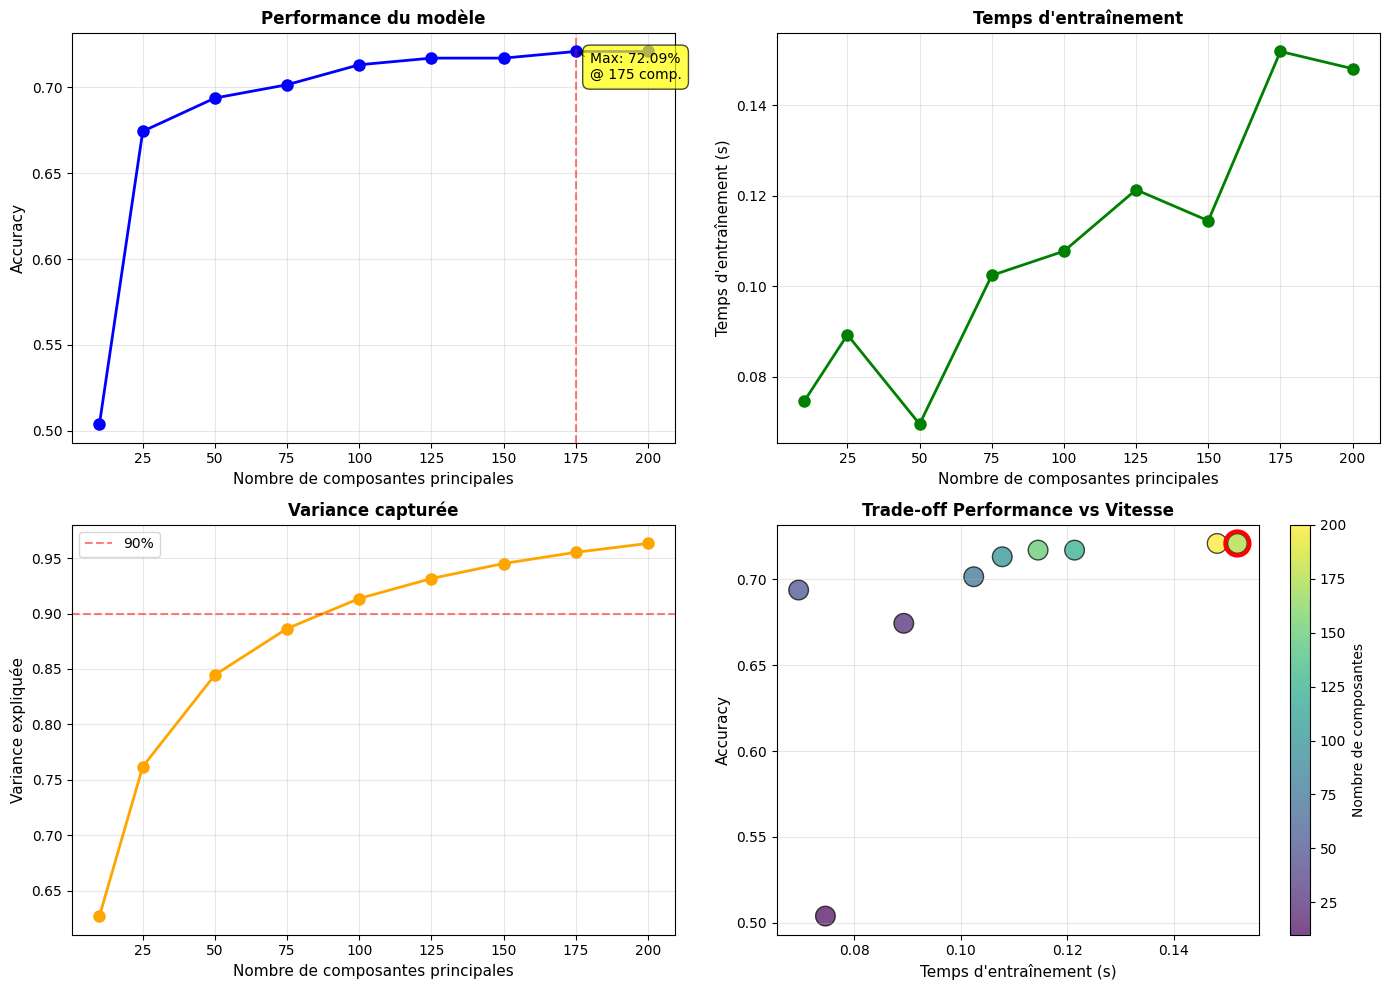


Meilleur résultat :
  - 175 composantes principales
  - Accuracy : 72.09%
  - Temps d'entraînement : 0.15s
  p Variance expliquée : 95.52%


In [61]:
# Extraction des résultats
n_comps = [r['n_components'] for r in results_optimization]
accuracies = [r['accuracy'] for r in results_optimization]
train_times = [r['train_time'] for r in results_optimization]
variances = [r['variance_explained'] for r in results_optimization]

# Création des graphiques
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Accuracy vs n_components
axes[0, 0].plot(n_comps, accuracies, 'o-', linewidth=2, markersize=8, color='blue')
axes[0, 0].set_xlabel('Nombre de composantes principales', fontsize=11)
axes[0, 0].set_ylabel('Accuracy', fontsize=11)
axes[0, 0].set_title('Performance du modèle', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
best_idx = np.argmax(accuracies)
axes[0, 0].axvline(x=n_comps[best_idx], color='red', linestyle='--', alpha=0.5)
axes[0, 0].annotate(f'Max: {accuracies[best_idx]:.2%}\n@ {n_comps[best_idx]} comp.',
                    xy=(n_comps[best_idx], accuracies[best_idx]),
                    xytext=(10, -20), textcoords='offset points',
                    bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.7),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# 2. Train time vs n_components
axes[0, 1].plot(n_comps, train_times, 'o-', linewidth=2, markersize=8, color='green')
axes[0, 1].set_xlabel('Nombre de composantes principales', fontsize=11)
axes[0, 1].set_ylabel('Temps d\'entraînement (s)', fontsize=11)
axes[0, 1].set_title('Temps d\'entraînement', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Variance expliquée vs n_components
axes[1, 0].plot(n_comps, variances, 'o-', linewidth=2, markersize=8, color='orange')
axes[1, 0].set_xlabel('Nombre de composantes principales', fontsize=11)
axes[1, 0].set_ylabel('Variance expliquée', fontsize=11)
axes[1, 0].set_title('Variance capturée', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0.9, color='red', linestyle='--', alpha=0.5, label='90%')
axes[1, 0].legend()

# 4. Trade-off Accuracy vs Train time
scatter = axes[1, 1].scatter(train_times, accuracies, c=n_comps, s=200, 
                             cmap='viridis', alpha=0.7, edgecolors='black')
axes[1, 1].set_xlabel('Temps d\'entraînement (s)', fontsize=11)
axes[1, 1].set_ylabel('Accuracy', fontsize=11)
axes[1, 1].set_title('Trade-off Performance vs Vitesse', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('Nombre de composantes', fontsize=10)

# Annotation du point optimal
axes[1, 1].scatter([train_times[best_idx]], [accuracies[best_idx]], 
                   s=300, facecolors='none', edgecolors='red', linewidths=3)

plt.tight_layout()
plt.show()

print(f"\nMeilleur résultat :")
print(f"  - {n_comps[best_idx]} composantes principales")
print(f"  - Accuracy : {accuracies[best_idx]:.2%}")
print(f"  - Temps d'entraînement : {train_times[best_idx]:.2f}s")
print(f"  p Variance expliquée : {variances[best_idx]:.2%}")

## 9. Impact du scaling et du balancing

### Effet du scaling (standardisation)

Le **scaling** consiste à centrer et réduire les données (moyenne=0, écart-type=1). C'est important pour de nombreux algorithmes de ML.

In [65]:
print("=" * 70)
print("EFFET DU SCALING SUR LES PERFORMANCES")
print("=" * 70)

# Sans scaling (déjà fait précédemment)
print("\nRésultats SANS scaling (référence) :")
print(f"  Accuracy : {accuracy_pca:.2%}")

# Avec scaling
print("\nEntraînement AVEC scaling...")

# Standardisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ACP sur données standardisées
pca_scaled = PCA(n_components=n_components_large, whiten=False, svd_solver='randomized')
X_train_pca_scaled = pca_scaled.fit_transform(X_train_scaled)
X_test_pca_scaled = pca_scaled.transform(X_test_scaled)

# Entraînement
start_time = time.time()
clf_scaled = SVC(kernel='rbf', gamma='scale', C=1.0, random_state=42)
clf_scaled.fit(X_train_pca_scaled, y_train)
train_time_scaled = time.time() - start_time

# Évaluation
y_pred_scaled = clf_scaled.predict(X_test_pca_scaled)
accuracy_scaled = accuracy_score(y_test, y_pred_scaled)

print(f"Entraînement terminé en {train_time_scaled:.2f} secondes")
print(f"\nRésultats AVEC scaling :")
print(f"  Accuracy : {accuracy_scaled:.2%}")

print("\n" + "-" * 70)
print("COMPARAISON :")
print(f"  Différence d'accuracy : {accuracy_scaled - accuracy_pca:+.2%}")
print(f"  Différence de temps : {train_time_scaled - train_time_pca:+.2f}s")

if accuracy_scaled > accuracy_pca:
    print("\nLe scaling AMÉLIORE les performances !")
elif accuracy_scaled < accuracy_pca:
    print("\nLe scaling DIMINUE légèrement les performances.")
else:
    print("\nLe scaling n'a PAS d'effet significatif.")

print("\nRapport de classification avec scaling :")
print(classification_report(y_test, y_pred_scaled, target_names=target_names))

EFFET DU SCALING SUR LES PERFORMANCES

Résultats SANS scaling (référence) :
  Accuracy : 72.09%

Entraînement AVEC scaling...
Entraînement terminé en 0.12 secondes

Résultats AVEC scaling :
  Accuracy : 73.26%

----------------------------------------------------------------------
COMPARAISON :
  Différence d'accuracy : +1.16%
  Différence de temps : -0.00s

Le scaling AMÉLIORE les performances !

Rapport de classification avec scaling :
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.38      0.55        16
     Colin Powell       0.84      0.89      0.87        47
  Donald Rumsfeld       0.87      0.54      0.67        24
    George W Bush       0.66      0.94      0.78       106
Gerhard Schroeder       0.70      0.32      0.44        22
      Hugo Chavez       1.00      0.43      0.60        14
       Tony Blair       0.75      0.52      0.61        29

         accuracy                           0.73       258
        macro avg       0

### Effet du balancing (équilibrage des classes)

Le **balancing** vise à donner le même poids à chaque classe lors de l'entraînement, ce qui est utile quand certaines classes sont sous-représentées.

In [67]:
print("=" * 70)
print("ANALYSE DU DÉSÉQUILIBRE DES CLASSES")
print("=" * 70)

# Analyse de la distribution
unique_train, counts_train = np.unique(y_train, return_counts=True)

print("\nDistribution des classes dans l'ensemble d'entraînement :")
for name, count in zip(target_names[unique_train], counts_train):
    print(f"  {name:30s} : {count:3d} images ({100*count/len(y_train):.1f}%)")

# Calcul du déséquilibre
max_count = counts_train.max()
min_count = counts_train.min()
imbalance_ratio = max_count / min_count

print(f"\nRatio de déséquilibre : {imbalance_ratio:.2f}")
print(f"Classe la plus représentée : {counts_train.max()} images")
print(f"Classe la moins représentée : {counts_train.min()} images")

if imbalance_ratio > 2:
    print("\nDéséquilibre significatif détecté ! Le balancing peut aider.")
else:
    print("\nDistribution relativement équilibrée.")

ANALYSE DU DÉSÉQUILIBRE DES CLASSES

Distribution des classes dans l'ensemble d'entraînement :
  Ariel Sharon                   :  61 images (5.9%)
  Colin Powell                   : 189 images (18.3%)
  Donald Rumsfeld                :  97 images (9.4%)
  George W Bush                  : 424 images (41.2%)
  Gerhard Schroeder              :  87 images (8.4%)
  Hugo Chavez                    :  57 images (5.5%)
  Tony Blair                     : 115 images (11.2%)

Ratio de déséquilibre : 7.44
Classe la plus représentée : 424 images
Classe la moins représentée : 57 images

Déséquilibre significatif détecté ! Le balancing peut aider.


In [68]:
print("=" * 70)
print("EFFET DU BALANCING SUR LES PERFORMANCES")
print("=" * 70)

# Avec balancing (class_weight='balanced')
print("\nEntraînement AVEC balancing...")

start_time = time.time()
clf_balanced = SVC(kernel='rbf', gamma='scale', C=1.0, 
                   class_weight='balanced', random_state=42)
clf_balanced.fit(X_train_pca_scaled, y_train)
train_time_balanced = time.time() - start_time

# Évaluation
y_pred_balanced = clf_balanced.predict(X_test_pca_scaled)
accuracy_balanced = accuracy_score(y_test, y_pred_balanced)

print(f"Entraînement terminé en {train_time_balanced:.2f} secondes")
print(f"\nRésultats AVEC balancing :")
print(f"  Accuracy : {accuracy_balanced:.2%}")

print("\n" + "-" * 70)
print("COMPARAISON :")
print(f"  Sans balancing : {accuracy_scaled:.2%}")
print(f"  Avec balancing : {accuracy_balanced:.2%}")
print(f"  Différence : {accuracy_balanced - accuracy_scaled:+.2%}")

if accuracy_balanced > accuracy_scaled:
    print("\nLe balancing AMÉLIORE les performances !")
    print("   Les classes minoritaires sont mieux reconnues.")
elif accuracy_balanced < accuracy_scaled:
    print("\nLe balancing DIMINUE légèrement les performances globales.")
    print("   Mais il peut améliorer les performances sur les classes minoritaires.")
else:
    print("\nLe balancing n'a PAS d'effet significatif sur l'accuracy globale.")

print("\nRapport de classification avec balancing :")
print(classification_report(y_test, y_pred_balanced, target_names=target_names))

EFFET DU BALANCING SUR LES PERFORMANCES

Entraînement AVEC balancing...
Entraînement terminé en 0.13 secondes

Résultats AVEC balancing :
  Accuracy : 80.23%

----------------------------------------------------------------------
COMPARAISON :
  Sans balancing : 73.26%
  Avec balancing : 80.23%
  Différence : +6.98%

Le balancing AMÉLIORE les performances !
   Les classes minoritaires sont mieux reconnues.

Rapport de classification avec balancing :
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.75      0.75        16
     Colin Powell       0.78      0.85      0.82        47
  Donald Rumsfeld       0.72      0.75      0.73        24
    George W Bush       0.91      0.89      0.90       106
Gerhard Schroeder       0.56      0.68      0.61        22
      Hugo Chavez       0.82      0.64      0.72        14
       Tony Blair       0.76      0.66      0.70        29

         accuracy                           0.80       258
        macro

### Comparaison finale de toutes les configurations

TABLEAU RÉCAPITULATIF DE TOUTES LES CONFIGURATIONS

Configuration                      Accuracy    Temps (s)     Features
--------------------------------------------------------------------------------
Sans ACP (référence)                72.48%        0.70         1850
Avec ACP (150 comp.)                72.09%        0.12          150
ACP + Scaling                       73.26%        0.12          150
ACP + Scaling + Balancing           80.23%        0.13          150



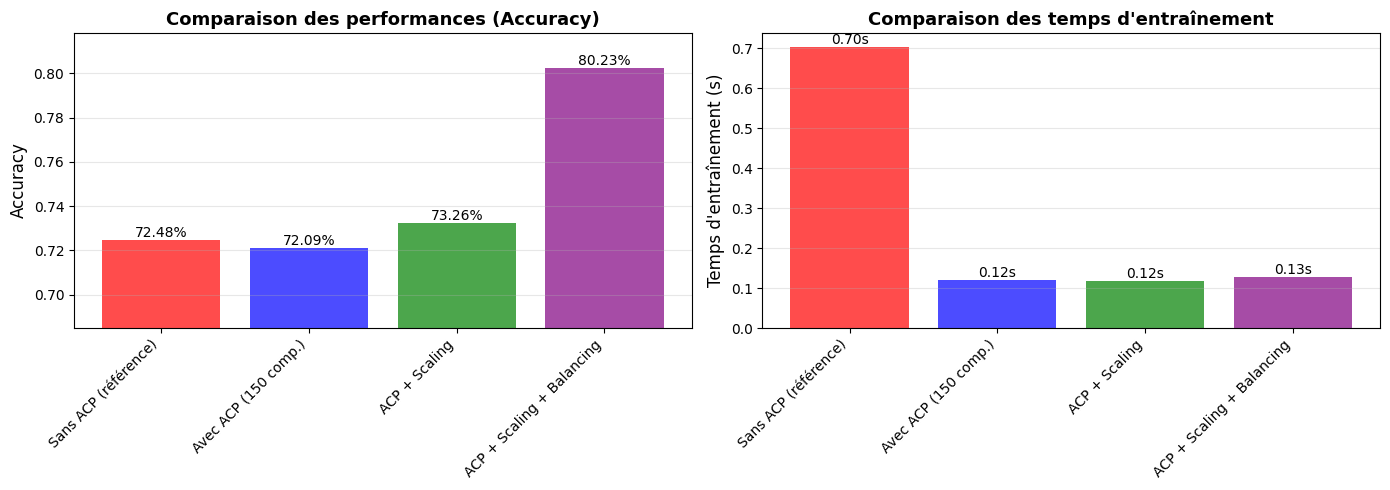


CONCLUSIONS :

1. Meilleure configuration (accuracy) : ACP + Scaling + Balancing
   Accuracy : 80.23%
   Temps : 0.13s

2. Configuration la plus rapide : ACP + Scaling
   Temps : 0.12s
   Accuracy : 73.26%

3. Gain de vitesse avec l'ACP : 5.8x plus rapide

4. Impact des prétraitements :
   - Scaling : +1.16%
   - Balancing : +6.98%
   - Total (ACP+Scaling+Balancing) : +7.75% vs référence


In [72]:
print("=" * 80)
print("TABLEAU RÉCAPITULATIF DE TOUTES LES CONFIGURATIONS")
print("=" * 80)

configurations = [
    ('Sans ACP (référence)', accuracy_original, train_time_original, n_features),
    (f'Avec ACP ({n_components_large} comp.)', accuracy_pca, train_time_pca, n_components_large),
    ('ACP + Scaling', accuracy_scaled, train_time_scaled, n_components_large),
    ('ACP + Scaling + Balancing', accuracy_balanced, train_time_balanced, n_components_large),
]

print(f"\n{'Configuration':<30} {'Accuracy':>12} {'Temps (s)':>12} {'Features':>12}")
print("-" * 80)

for config_name, acc, time_val, n_feat in configurations:
    print(f"{config_name:<30} {acc:>11.2%} {time_val:>11.2f} {n_feat:>12}")

print("\n" + "=" * 80)

# Visualisation graphique
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

config_names = [c[0] for c in configurations]
accuracies_all = [c[1] for c in configurations]
times_all = [c[2] for c in configurations]

# Graphique des accuracies
colors = ['red', 'blue', 'green', 'purple']
bars1 = ax1.bar(range(len(config_names)), accuracies_all, color=colors, alpha=0.7)
ax1.set_xticks(range(len(config_names)))
ax1.set_xticklabels(config_names, rotation=45, ha='right')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Comparaison des performances (Accuracy)', fontsize=13, fontweight='bold')
ax1.set_ylim([min(accuracies_all) * 0.95, max(accuracies_all) * 1.02])
ax1.grid(axis='y', alpha=0.3)

# Ajout des valeurs sur les barres
for bar, acc in zip(bars1, accuracies_all):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.2%}', ha='center', va='bottom', fontsize=10)

# Graphique des temps
bars2 = ax2.bar(range(len(config_names)), times_all, color=colors, alpha=0.7)
ax2.set_xticks(range(len(config_names)))
ax2.set_xticklabels(config_names, rotation=45, ha='right')
ax2.set_ylabel('Temps d\'entraînement (s)', fontsize=12)
ax2.set_title('Comparaison des temps d\'entraînement', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Ajout des valeurs sur les barres
for bar, time_val in zip(bars2, times_all):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{time_val:.2f}s', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Conclusions
best_config_idx = np.argmax(accuracies_all)
fastest_config_idx = np.argmin(times_all)

print("\nCONCLUSIONS :")
print(f"\n1. Meilleure configuration (accuracy) : {config_names[best_config_idx]}")
print(f"   Accuracy : {accuracies_all[best_config_idx]:.2%}")
print(f"   Temps : {times_all[best_config_idx]:.2f}s")

print(f"\n2. Configuration la plus rapide : {config_names[fastest_config_idx]}")
print(f"   Temps : {times_all[fastest_config_idx]:.2f}s")
print(f"   Accuracy : {accuracies_all[fastest_config_idx]:.2%}")

speedup_final = times_all[0] / times_all[1]
print(f"\n3. Gain de vitesse avec l'ACP : {speedup_final:.1f}x plus rapide")

print("\n4. Impact des prétraitements :")
print(f"   - Scaling : {accuracies_all[2] - accuracies_all[1]:+.2%}")
print(f"   - Balancing : {accuracies_all[3] - accuracies_all[2]:+.2%}")
print(f"   - Total (ACP+Scaling+Balancing) : {accuracies_all[3] - accuracies_all[0]:+.2%} vs référence")

## Conclusion du TP

### Ce que nous avons appris :

1. **Problème de dimensionnalité** : Trop de features par rapport au nombre d'observations peut nuire aux performances et ralentir l'entraînement.

2. **L'ACP comme solution** : La réduction de dimensionnalité via ACP permet de :
   - Accélérer significativement l'entraînement
   - Réduire le surapprentissage
   - Parfois même améliorer les performances

3. **Eigenfaces** : Les composantes principales représentent des "visages types" qui capturent les variations principales dans les données.

4. **Compression d'images** : L'ACP peut être utilisée pour compresser des images en ne gardant que les composantes les plus importantes.

5. **Optimisation** : Le choix du nombre de composantes est un compromis entre :
   - La quantité d'information conservée (variance expliquée)
   - La vitesse de calcul
   - Les performances du modèle

6. **Prétraitements** :
   - Le **scaling** peut améliorer les performances en normalisant les données
   - Le **balancing** aide quand les classes sont déséquilibrées

### Points clés à retenir :

- L'ACP est une technique de **réduction de dimensionnalité linéaire**
- Elle trouve les directions de variance maximale dans les données
- C'est un outil puissant pour la **visualisation**, la **compression** et l'**accélération** des algorithmes de ML
- Elle doit être appliquée sur l'ensemble d'entraînement et les mêmes transformations appliquées au test
- Le nombre de composantes est un hyperparamètre à optimiser